In [36]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import pystan
import scipy.stats as stats

plt.rc('text', usetex=True)

# Baseball example

We are going to use a hierarchical model with 3 levels to estimate the batting performance in the 2012 MLB season.. We are interested on estimating the performance both at the player ($\theta_{s|c}$) and position played level ($\omega_{c}$). 

$$
\begin{align*}
y_{i,s|c} &\sim Binomial(N_{s|c}, \theta_{s|c}) &\text{ where } s \in [0, \dots S] \text{ and } c \in [0, \dots C]\\
\theta_{s|c} &\sim Beta(\omega_{c} * (\kappa_{c} - 2) + 1, (1 - \omega_{c})*(k_{c} - 2) + 1) \\
\kappa_{c} &\sim Gamma(S_{\kappa}, R_{\kappa}) \\
\omega_{c} &\sim Beta(\omega * (\kappa - 2) + 1, (1 - \omega)*(k - 2) + 1) \\
\omega &\sim Beta(A_{\omega}, B_{\omega}) &\text{ where } A_{\omega} = B_{\omega} = 1 \\
\kappa &\sim Gamma(S_{\kappa}, R_{\kappa}) &\text{ where } S_{\kappa} = R_{\kappa} = 0.01 \\
\end{align*}
$$

From the above mathematical formulation of the model, you can see that we are using a Binomial likelihood function. $\theta_{s|c}$ has a Beta prior which is specific for each position, and whose parameters ($\omega_{c}$ and $\kappa_{c}$) are also estimated within the model and have their own priors.

The choice of using mode ($\omega_{c}$) and concentration ($\kappa_{c}$) to describe the Beta prior is justified by the fact that we are interested on making comparisons between the performance at the player level and at the position level. In this way we can observe how much a player differs from it's own group of peers playing in the same role, or conversely how much the mode at the concentration parameters are influencing the estimate for players which haven't played a lot.

For further details about the model, please consult the book.

The dataset contains observations for 947 players during the 2012 MLB season. Each record in the dataset corresponds to a player, and statistics for `At Bats` and `Hit` are reported, also the player's position (`PriPosNumber`).

In [37]:
baseball = pd.read_csv('./data/BattingAverage.csv')
baseball = baseball.sort_values('PriPosNumber').reset_index(drop=True)
baseball.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,1,1
1,Brad Lincoln,Pitcher,2,10,511,1
2,Tim Lincecum,Pitcher,4,45,510,1
3,Ted Lilly,Pitcher,1,15,508,1
4,Colby Lewis,Pitcher,2,4,504,1


Just to get more familiar with the dataset, we are going to compute the mean and standard deviation of the Batting Average (also abbreviated AVG) by role.

In [38]:
baseball['AV'] = baseball.Hits / baseball.AtBats
position = pd.DataFrame({'mean': baseball.groupby('PriPosNumber').AV.mean(),
                         'std': baseball.groupby('PriPosNumber').AV.std()})
position

,mean,std
PriPosNumber,,
1,0.100720,0.146356
2,0.215879,0.082086
3,0.238236,0.057819
4,0.232277,0.074944
5,0.241020,0.057538
6,0.242272,0.051239
7,0.228433,0.068423
8,0.250707,0.075097
9,0.248785,0.039830


From the summary table above we can see that pitchers (`PriPosNumber` = 1) don't have very good batting averages. Players in other roles have much better statistics, but it's not clear from this table if there is any significant difference. We will answer this question when analysing the traces of our model.

We will now organise in a convenient format the data we need to fit the model in Stan.

In [39]:
at_bat = baseball.AtBats.values
hits = baseball.Hits.values
positions = baseball.PriPosNumber.values
n_positions = baseball.PriPosNumber.nunique()

counts = baseball.groupby('PriPosNumber').PlayerNumber.count()
start = [1]
for idx, count in enumerate(counts):
    starting_point = start[idx] + count
    start.extend([starting_point])
    
length = [start[idx+1] - start[idx] for idx in range(len(start)-1) ]

variables = [at_bat, hits, positions, n_positions, start, length]
for variable in variables:
    print(variable)

[  7  10  45  15   4   5   1  64   1  12  61  65   9   3   1  53   1  20
  58  51  36  33  10  28  13  53   5   2   1  11   1   3   1   2   3  33
   5   4  49   2   1   4   4  64   1   2   3   1  32  38   2  63  50  38
  11   4   1   2  57   2   2  33   1   6  64   9   4   1  17  27   8  30
  40  25   1   8  25  31   1   2   7  32   2   4   1  40  32  67   3  53
  69   5   2   1  55  13   2   5   1   1   4   3   1   1   2   1  20   1
  18   5  59   4  56  32  49   1   1   4  65   3   5   5   9   5   5   1
   2  10  28  47   1   1   6   1  14   7   5  13   4   2   1   2  35  35
   4   5  30   1   4   5   4   2  57   4  34   2   2  37  53   1  40   5
   4   8  28  49  12   4  12   5   1   2   1   6  66  28  56  54   1  50
   1   2   5   5   2   1   6   1   2  12   9   1  16   2   7   6  50   4
  55  18   3  13   1  11  13   1   2   4  55  56   1  11   1   1  12   2
   2   3   5  14   3  12  61   3   1   2  69   3   3   1   1   3   1  10
   3   4   2  26   4   1   1   1   1   1   7  68   

We now need to organise the data into a dictionary, whose keys are also the name of the variables specified in the `data` block of the Stan model.

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d34d6dc95a81207bc6e7bb00bca3620 NOW.


Inference for Stan model: anon_model_1d34d6dc95a81207bc6e7bb00bca3620.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
omega0             0.23  2.6e-4   0.02   0.18   0.21   0.23   0.24   0.27   8079    1.0
omega[0]           0.12  1.8e-4 6.3e-3   0.11   0.12   0.12   0.13   0.13   1236    1.0
omega[1]           0.24  5.4e-5 5.3e-3   0.23   0.23   0.24   0.24   0.25   9472    1.0
omega[2]           0.25  4.9e-5 4.9e-3   0.24   0.25   0.25   0.25   0.26   9887    1.0
omega[3]           0.25  5.3e-5 5.2e-3   0.24   0.25   0.25   0.25   0.26   9443    1.0
omega[4]           0.25  5.5e-5 5.4e-3   0.24   0.25   0.26   0.26   0.27   9502    1.0
omega[5]           0.25  5.6e-5 5.6e-3   0.24   0.24   0.25   0.25   0.26  10159    1.0
omega[6]           0.25  5.4e-5 5.0e-3   0.24   0.25   0.25   0.25   0.26   8410    1.0
omega[7]         

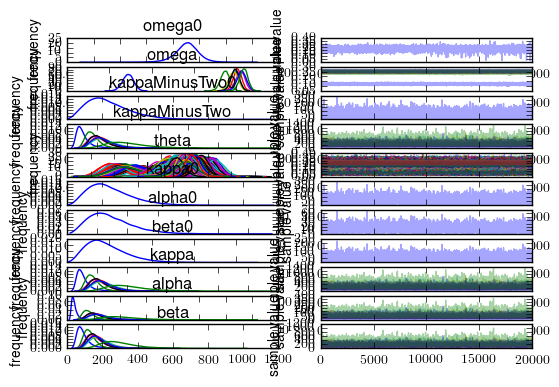

In [40]:
baseball_data = {
    'P': baseball.shape[0],
    'positions': positions,
    'start': start,
    'length': length,
    'N_positions': n_positions,
    'N': at_bat,
    'y': hits,
    'S': 0.01,
    'R': 0.01,
    'A': 1,
    'B': 1
}

fit = pystan.stan(file='baseball.stan', data=baseball_data,
                  iter=10000, chains=4)

print(fit)
fit.plot()
plt.show()

Looking at the results, in particular at the values of the position mode, $\omega_{c}$, we notice that pitchers are extremely bad at batting. They are consistently poorer hitters than any other player in a different role. Catchers are also slightly worse hitters than other players, but are not as bad at pitchers.

To facilitale the reading of the above summary table, let's refresh the indices of each position.

In [41]:
baseball.groupby(['PriPosNumber', 'PriPos']).Player.nunique()

PriPosNumber  PriPos      
1             Pitcher         324
2             Catcher         103
3             1st Base         81
4             2nd Base         72
5             3rd Base         75
6             Shortstop        63
7             Left Field      103
8             Center Field     67
9             Right Field      60
Name: Player, dtype: int64

We might wonder if pitchers have, on average, worse performance at batting than catchers. We can compute the probability simply computing the ratio of samples extracted from the difference of the two posterior modes ($\omega$s) that is lower than zero.

In [42]:
pitchers = fit.extract(permuted=True)['omega'][:,0]
catchers = fit.extract(permuted=True)['omega'][:,1]

difference = pitchers - catchers
np.mean(difference < 0)

1.0

We can summarise the batting performance comparison between the two positions using the following graphs. In the upper left and lower right are displayed the marginal posterior densities. In the upper right the posterior density of the difference. In the lower left graphs is a scatterplot, which tells us the two samples from the marginal posterior distributions are uncorrelated.

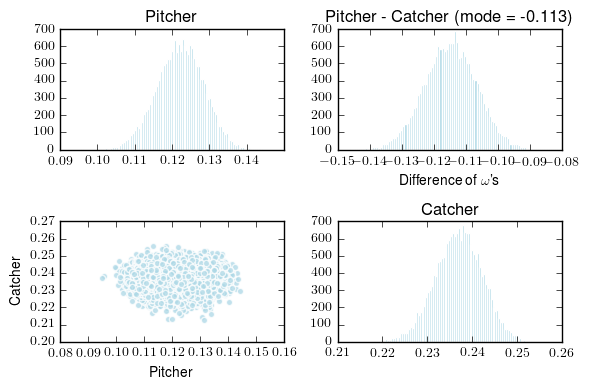

In [43]:
mode = stats.mode([round(i, 3) for i in difference])

plt.subplot(2,2,1)
plt.hist(pitchers, bins=100, color='lightblue', edgecolor='white')
plt.title('Pitcher')

plt.subplot(2,2,2)
plt.hist(difference, bins=100, color='lightblue', edgecolor='white')
plt.xlabel(r"Difference of $\omega$'s")
plt.title('Pitcher - Catcher (mode = {})'.format(mode[0][0]))

plt.subplot(2,2,3)
plt.scatter(pitchers, catchers, marker='o', color='lightblue', edgecolor='white', alpha=.75)
plt.xlabel('Pitcher')
plt.ylabel('Catcher')
plt.xlim(0.08, 0.16); plt.ylim(0.20, 0.27)

plt.subplot(2,2,4)
plt.hist(catchers, bins=100, color='lightblue', edgecolor='white')
plt.title('Catcher')

plt.tight_layout()
plt.show()

A perhaps more interesting comparison could be made between 1st base and right field players. In this case, although there is sufficient evidence that right field players have better batting performance, this is not as conclusive as in the previous comparison.

In [44]:
firstbase = fit.extract()['omega'][:,2]
rightfield = fit.extract()['omega'][:,8]
diff = firstbase - rightfield
np.mean(diff < 0)

0.86499999999999999

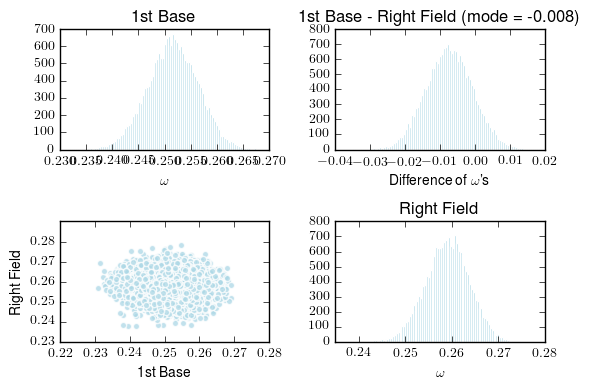

In [45]:
mode = stats.mode([round(i, 3) for i in diff])

plt.subplot(2,2,1)
plt.hist(firstbase, bins=100, color='lightblue', edgecolor='white')
plt.title('1st Base')
plt.xlabel(r'$\omega$')

plt.subplot(2,2,2)
plt.hist(diff, bins=100, color='lightblue', edgecolor='white')
plt.xlabel(r"Difference of $\omega$'s")
plt.title('1st Base - Right Field (mode = {})'.format(mode[0][0]))

plt.subplot(2,2,3)
plt.scatter(firstbase, rightfield, marker='o', color='lightblue', edgecolor='white', alpha=.75)
plt.xlabel('1st Base')
plt.ylabel('Right Field')
plt.xlim(0.22, 0.28); plt.ylim(0.23, 0.29)

plt.subplot(2,2,4)
plt.hist(rightfield, bins=100, color='lightblue', edgecolor='white')
plt.title('Right Field')
plt.xlabel(r'$\omega$')

plt.tight_layout()
plt.show()